# cGAN (conditional GAN) implementation Using Pytorch

## Implementation Starts here

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

from tqdm.auto import tqdm

### Non-Convolutional GAN

In [2]:
# Generator

class Generator(nn.Module):
    def __init__(self, input_size_z = 100, input_size_condition= 100, hidden_size = 256, output_size = 784, layers = 1,leaky = 0.2, device = 'cuda'):
        super().__init__()

        self.device = device

        self.init_layer = nn.Sequential(
            nn.Linear(input_size_z +input_size_condition, 800, device = self.device),
            nn.LeakyReLU(leaky),
        )

        self.combine = nn.Sequential(
            nn.Linear(800, hidden_size, device = self.device),
            nn.LeakyReLU(leaky),
        )

        self.layer = nn.ModuleList([nn.Sequential(
            nn.Linear(hidden_size, hidden_size, device = self.device),
            nn.LeakyReLU(leaky),
        ) for _ in range(layers-1)])

        self.final = nn.Sequential(
            nn.Linear(hidden_size, output_size, device = self.device),
            nn.Tanh()
        )

    def forward(self, z, y):
        """
        z: the vector 
        y: the label for the vector
        """
        z = z.to(self.device)
        y = y.to(self.device)

        combined = self.init_layer(torch.cat((z, y), dim=1))
        combined = self.combine(combined)

        for layer in self.layer:
            combined = layer(combined)
            
        return self.final(combined) # logits 

In [3]:
def test_generator():
    gen = Generator(input_size_z=100, input_size_condition=10, output_size=784, layers=3, device='cuda')
    noise = torch.randn(1, 100)
    label = torch.randn(1, 10)

    output = gen(noise, label)
    assert output.shape == (1, 784)
    print("Generator test passed")
test_generator()

Generator test passed


In [4]:
# Discriminator - not using maxout because of instability issues

class Discriminator(nn.Module):
    def __init__(self, d_in =784, d_label = 10, hidden_size=256, d_out =1, leaky = 0.2, dropout = 0.5, device='cuda'):
        super().__init__()

        self.device = device

        self.dropout = nn.Dropout(dropout)

        self.label_embed = nn.Linear(d_label, hidden_size, device = self.device)

        self.model = nn.Sequential(
            nn.Linear(d_in + hidden_size, hidden_size, device = self.device),
            nn.LeakyReLU(leaky),
            nn.Linear(hidden_size, hidden_size, device = self.device),
            nn.LeakyReLU(leaky),
            nn.Linear(hidden_size, d_out, device = self.device)
        )

        
    def forward(self, x, y):
        x = x.to(self.device)

        y = y.to(self.device, dtype=torch.float32)
        
        y = self.label_embed(y)

        combined = torch.cat((x,y), dim =1)

        logits = self.dropout(self.model(combined))

        return logits # torch.sigmoid(combined) or torch.tanh(combined) - used with loss

In [5]:
# Unit testing for Discriminator

def test_discriminator():
   disc = Discriminator(d_in = 784, d_label = 10, hidden_size=256, d_out =1, leaky = 0.2, dropout = 0.5, device='cuda')
   x = torch.randn(1, 784)
   y = torch.randn(1, 10)

   output = disc(x, y)
   assert output.shape == (1, 1)
   print("Discriminator test passed")
test_discriminator()

Discriminator test passed


#### Training and Testing Loops

In [18]:
#Hyperparameters
DISC_LR= 0.01
GEN_LR= 0.1
MIN_LR = 0.000001
DECAY_FACTOR = 1.00004
DROPOUT = 0.5
INIT_MOMENTUM = 0.5
MAX_MOMENTUM = 0.7
BATCH_SIZE = 50
EPOCHS = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
def train(gen, disc, optim_gen, optim_disc, scheduler_gen, scheduler_disc, criterion_gen, criterion_disc, train_loader, device):
    gen.train()
    disc.train()

    for x, y in train_loader:
        # x is the real data
        # y is the labels

        x = x.view(x.shape[0], -1).to(device)
        y = y.unsqueeze(1).to(device)


        optim_gen.zero_grad()
        optim_disc.zero_grad()
        
        z = torch.randn(x.shape[0], 784).to(device)
        gen_out = gen(z, y)

        # Discriminator predictions
        disc_out_real = disc(x, y)  # D(real)
        disc_out_fake = disc(gen_out.detach(), y)  # D(fake), detach G to avoid gradient flow to Generator

        # Create real and fake labels
        real_labels = torch.ones_like(disc_out_real)
        fake_labels = torch.zeros_like(disc_out_fake)

        # Compute Discriminator loss
        loss_disc_real = criterion_disc(disc_out_real, real_labels)  # D(x) should be 1
        loss_disc_fake = criterion_disc(disc_out_fake, fake_labels)  # D(G(z)) should be 0
        loss_disc = (loss_disc_real + loss_disc_fake) / 2

        loss_disc.backward()

        #thresholding the loss
        if loss_disc > 0.6:
            optim_disc.step()
 
        # Train Generator (G)
        # Recalculate fake images (since .detach() was used before)
        gen_out = gen(z, y)
        disc_out_fake = disc(gen_out, y)  # D(G(z)), should be classified as real

        # Compute Generator loss
        real_labels = torch.ones_like(disc_out_fake)  # Generator wants D to classify as real
        loss_gen = criterion_gen(disc_out_fake, real_labels)

        loss_gen.backward()
        optim_gen.step()
     
        scheduler_gen.step()
        scheduler_disc.step()

In [8]:
def test(gen, disc, criterion_gen, criterion_disc, test_loader, device):
    gen.eval()
    disc.eval()
    with torch.inference_mode():
        sample_gen = None
        disc_loss = 0 
        gen_loss = 0
        for x, y in test_loader:
            x = x.view(x.shape[0], -1).to(device)
            y = y.unsqueeze(1).to(device)

            z = torch.randn(x.shape[0], 784).to(device)
            gen_out = gen(z, y)

            disc_out_real = disc(x, y)
            disc_out_fake = disc(gen_out, y)

            real_labels = torch.ones_like(disc_out_real)
            fake_labels = torch.zeros_like(disc_out_fake)

            loss_disc_real = criterion_disc(disc_out_real, real_labels)
            loss_disc_fake = criterion_disc(disc_out_fake, fake_labels)
            loss_disc = (loss_disc_real + loss_disc_fake) / 2

            loss_gen = criterion_gen(disc_out_fake, real_labels)

            disc_loss += loss_disc.item()
            gen_loss += loss_gen.item()

            
            sample_gen  = torch.stack([x, gen_out], dim=1)
        
        return sample_gen, disc_loss/len(test_loader), gen_loss/len(test_loader)

In [19]:
def visualize(sample_gen):
    sample_gen = sample_gen.reshape(-1, 1, 28, 28)
    plt.figure(figsize=(15,15))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(np.transpose(vutils.make_grid(sample_gen, padding=2, normalize=True).cpu(), (1,2,0)))
    plt.show()

In [14]:
def train_and_test(gen, disc, optim_gen, optim_disc, scheduler_gen, scheduler_disc, criterion_gen, criterion_disc, train_loader, test_loader, epochs, device):
    for i in tqdm(range(epochs)):
        train(gen, disc, optim_gen, optim_disc, scheduler_gen, scheduler_disc, criterion_gen, criterion_disc, train_loader, device)
        sample_gen, disc_loss, gen_loss = test(gen, disc, criterion_gen, criterion_disc, test_loader, device)
        if (i+1) % 10 == 0:
            print(f"Epoch: {i}, Discriminator loss: {disc_loss}, Generator loss: {gen_loss}") 

    visualize(sample_gen)

#### Data (MNIST)

In [15]:
import torchvision.datasets as datasets

train_dataset = datasets.MNIST(
    root='./train_data', train=True, download=True, transform=transforms.ToTensor()
)
test_dataset = datasets.MNIST(
    root='./test_data', train=False, download=True, transform=transforms.ToTensor()
)


In [20]:
# Data loaders 
train_loader, test_loader = DataLoader(train_dataset,batch_size = BATCH_SIZE, shuffle= True), DataLoader(test_dataset,batch_size = BATCH_SIZE, shuffle= True)

#### Actual Training

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9, Discriminator loss: 0.6483543375134468, Generator loss: 0.7395919916033745
Epoch: 19, Discriminator loss: 0.6843737459182739, Generator loss: 0.7362351730465889
Epoch: 29, Discriminator loss: 0.681705974638462, Generator loss: 0.6615716674923897
Epoch: 39, Discriminator loss: 0.689820816218853, Generator loss: 0.71456274330616
Epoch: 49, Discriminator loss: 0.6730622687935829, Generator loss: 0.6884692993760109
Epoch: 59, Discriminator loss: 0.6931547522544861, Generator loss: 0.697030782699585
Epoch: 69, Discriminator loss: 0.6931838989257812, Generator loss: 0.6846144199371338
Epoch: 79, Discriminator loss: 0.6931910514831543, Generator loss: 0.7025665640830994
Epoch: 89, Discriminator loss: 0.6939746141433716, Generator loss: 0.6532896161079407
Epoch: 99, Discriminator loss: 0.6931488513946533, Generator loss: 0.6950002312660217


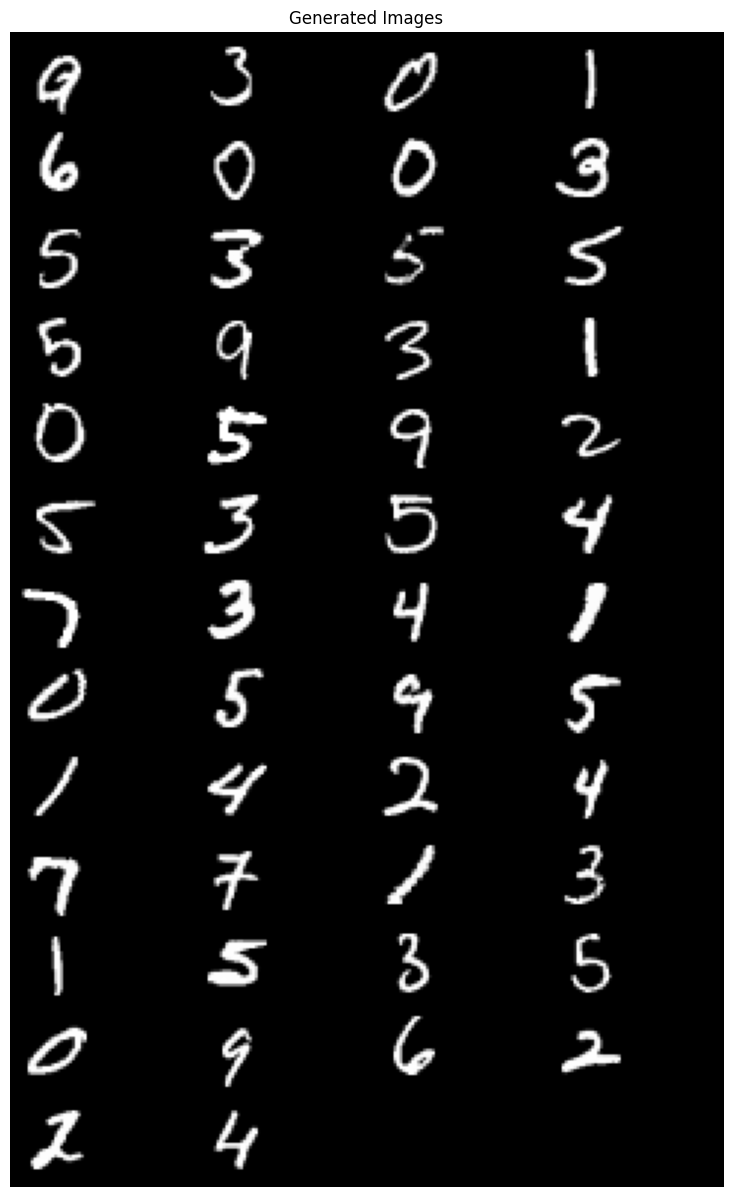

In [21]:
gen = Generator(input_size_z=784, input_size_condition=1, output_size=784, hidden_size=256, layers=3, device=device)
disc = Discriminator(d_in = 784, d_label = 1, hidden_size=256, d_out =1, leaky = 0.2, dropout = DROPOUT,device=device)

optim_gen = optim.SGD(gen.parameters(), lr=GEN_LR, momentum=INIT_MOMENTUM, weight_decay=0.0001)
optim_disc = optim.SGD(disc.parameters(), lr=DISC_LR, momentum=INIT_MOMENTUM,weight_decay=0.01)

scheduler_gen = optim.lr_scheduler.ExponentialLR(optim_gen, DECAY_FACTOR) 
scheduler_disc = optim.lr_scheduler.ExponentialLR(optim_disc, DECAY_FACTOR)

criterion_gen = nn.BCEWithLogitsLoss() # we use the raw logits
criterion_disc = nn.BCEWithLogitsLoss() # we use the raw logits


gen = gen.to(device)
disc = disc.to(device)

# "updated training code and hyper- parameters but  Discriminator performs better so need to apply augmentation while training generator for it to get better and omly updated discriminator above a certain loss threshold"
train_and_test(gen, disc, optim_gen, optim_disc, scheduler_gen, scheduler_disc, criterion_gen, criterion_disc, train_loader, test_loader, EPOCHS, device)